In [35]:
import os # The OS module in Python provides functions for interacting with the operating system
import matplotlib.pyplot as plt # library for creating static, animated, and interactive visualizations
import shutil # file manupilation
from tqdm import tqdm # creating Progress Meters or Progress Bars
import distutils # provides support for building and installing additional modules into a Python installation
from distutils import dir_util # provides functions for operating on directories and trees of directories
import tensorflow as tf # ML lib
from tensorflow import keras # ML lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator # multiply images
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np # arithmatic calculations 
import pandas as pd
from sklearn.model_selection import train_test_split # Ml lib
import matplotlib.pyplot as plt # draw graphs
from matplotlib.pyplot import imshow
from tensorflow.keras.applications.mobilenet import MobileNet

In [36]:
DIR = '../datasets/Betel classification'

In [37]:
CLASSES = os.listdir(DIR)
CLASSES.sort()
print(CLASSES)

['Maneru', 'Naagawalli']


# Data Augmentation

In [38]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,width_shift_range=0.2,
    height_shift_range=0.2, brightness_range=(0.2, 0.8),
    shear_range=0.2, zoom_range=0.2,
    channel_shift_range=0.2, fill_mode='nearest',
    horizontal_flip=True, vertical_flip=True,
    rescale=1./255, validation_split=0.2, 
    dtype=None
)

In [39]:
train_gen = image_gen.flow_from_directory(
    DIR,
    target_size=(224, 224),
    batch_size=64,
    subset='training',
    shuffle=True,
    classes=CLASSES
)

Found 24 images belonging to 2 classes.


In [40]:
validation_gen = image_gen.flow_from_directory(
    DIR,
    target_size=(224, 224),
    batch_size=64,
    subset='validation',
    shuffle=True,
    classes=CLASSES
)

Found 6 images belonging to 2 classes.


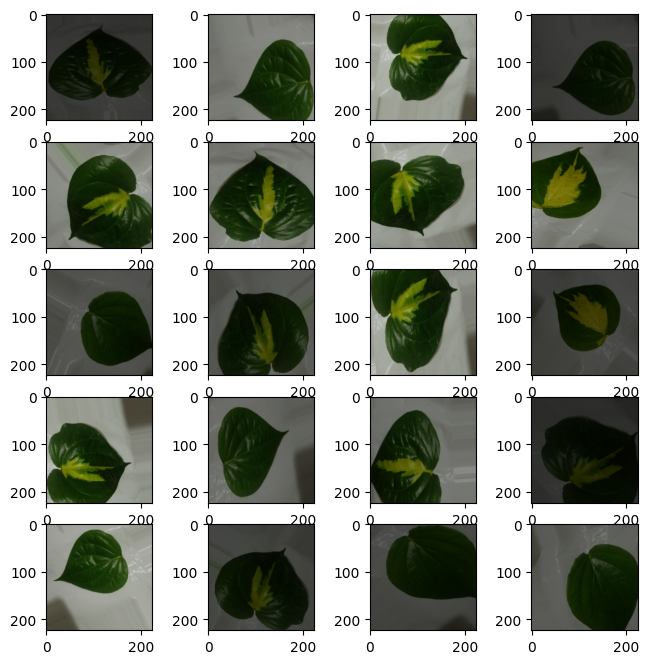

In [41]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img, label = train_gen.next()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img[0])
    img.size
plt.show()

# Model Building

### MobileNet Model

In [42]:
def create_model():
    mobile_net = MobileNet()

    m_net_model = Sequential()

    for layer in mobile_net.layers[: -1]: # add layers axcept lat dense layer[: -1]
        m_net_model.add(layer) # add each layer in vgg16 to Sequential model

    m_net_model.add(Dense(len(CLASSES), activation='softmax'))
    m_net_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return m_net_model

In [43]:
m_net_model = create_model()

In [44]:
def train(train_gen, val_gen, epochs=10):
    m_net_hist = m_net_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        verbose=1
    )

    return m_net_hist

m_net_hist = train(train_gen, validation_gen, 50)

Epoch 1/50
1/1 [==============================] - 1s 611ms/step - loss: 2.7409 - accuracy: 0.4167 - val_loss: 1.9131 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 320ms/step - loss: 0.5278 - accuracy: 0.8333 - val_loss: 0.9824 - val_accuracy: 0.6667
Epoch 3/50
1/1 [==============================] - 0s 343ms/step - loss: 0.1909 - accuracy: 0.8750 - val_loss: 2.0941 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 351ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 0.8957 - val_accuracy: 0.6667
Epoch 5/50
1/1 [==============================] - 0s 434ms/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 1.4660 - val_accuracy: 0.5000
Epoch 6/50
1/1 [==============================] - 0s 419ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 2.9056 - val_accuracy: 0.5000

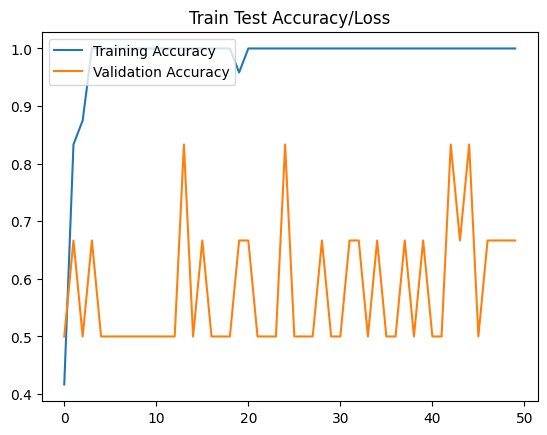

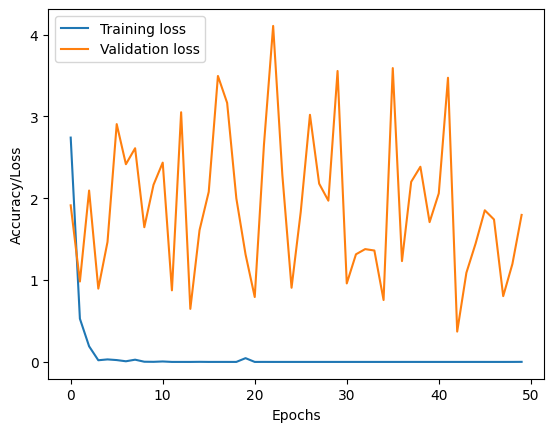

In [45]:
# accuracy curve
plt.plot(m_net_hist.history['accuracy'])
plt.plot(m_net_hist.history['val_accuracy'])
plt.title('Train Test Accuracy/Loss')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

plt.plot(m_net_hist.history['loss'])
plt.plot(m_net_hist.history['val_loss'])
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

# Custom Model Building

In [46]:
from tensorflow.keras import regularizers

def create_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3),input_shape=(224,224,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(len(CLASSES), activation="softmax"))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [47]:
model = create_model()

In [48]:
def train(train_gen, val_gen, epochs=10):
    hist = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        verbose=1
    )
    return hist

hist = train(train_gen, validation_gen, 50)

Epoch 1/50
1/1 [==============================] - 1s 588ms/step - loss: 8.3468 - accuracy: 0.5417 - val_loss: 8.1751 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 429ms/step - loss: 8.2046 - accuracy: 0.5000 - val_loss: 8.0389 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 468ms/step - loss: 8.0307 - accuracy: 0.5000 - val_loss: 7.8560 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 418ms/step - loss: 7.8782 - accuracy: 0.5000 - val_loss: 7.7151 - val_accuracy: 0.5000
Epoch 5/50
1/1 [==============================] - 0s 384ms/step - loss: 7.7194 - accuracy: 0.5000 - val_loss: 7.5988 - val_accuracy: 0.3333
Epoch 6/50
1/1 [==============================] - 0s 445ms/step - loss: 7.5719 - accuracy: 0.5417 - val_loss: 7.4183 - val_accuracy: 0.3333

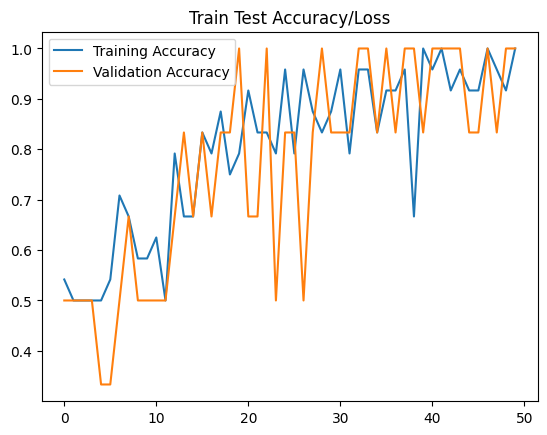

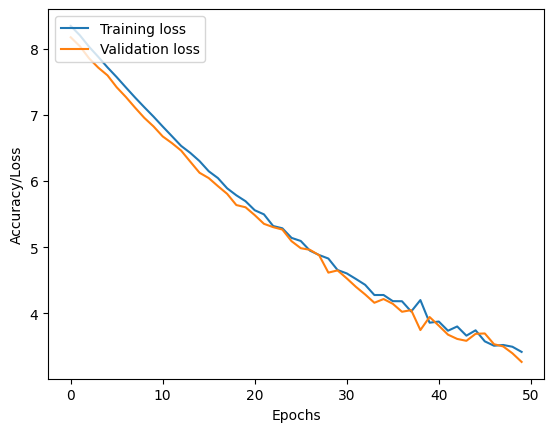

In [49]:
# accuracy curve
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Train Test Accuracy/Loss')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

# Save Model

In [51]:
model.save('./saved_models/leaf_identification_model.h5')

# Test Run

## diseases_check_trained_model

In [52]:
# loading model

loaded_model = load_model('./saved_models/leaf_identification_model.h5')

In [53]:
img_path = '../datasets/Betel classification/Maneru/4.jpeg'

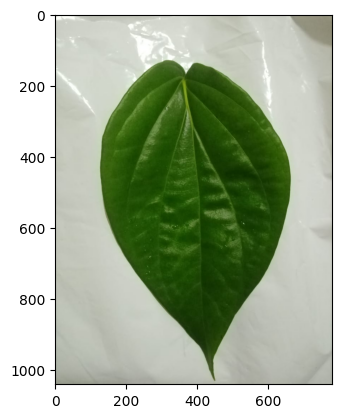

In [54]:
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(img_path)
imshow(testim)

In [55]:
import cv2

def get_processed_input_img(image_path, size=224):
  test_img = cv2.imread(image_path)
  test_img = cv2.resize(test_img, dsize=(size, size), interpolation=cv2.INTER_AREA)

  test_img = test_img.reshape((1, size, size, 3)).astype(np.float32)

  return test_img/225

In [56]:
processed_img = get_processed_input_img(img_path)

In [57]:
pred = loaded_model.predict(processed_img)
print(pred)

[[9.999529e-01 4.711417e-05]]


In [58]:
# inversely sorted array with indexes
best_idx = (-pred).argsort()[0]
print(best_idx)
# output
# [0.10135, 0.32547, 0.28438]
# [1, 2, 0]   <--- array element indexes for the results

[0 1]


In [59]:
# to textual form
print([CLASSES[i] for i in best_idx])

['Maneru', 'Naagawalli']


In [60]:
for i in best_idx:
  print('{} probability: {}'.format(CLASSES[i], pred[0][i]))




Maneru probability: 0.9999529123306274
Naagawalli probability: 4.711416841018945e-05
